## 0.参数配置

In [9]:
import os
import sys
BASE_DIR = os.getcwd()
sys.path.append(os.path.join(BASE_DIR, '..'))
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from models.deeplab import DeepLabV3Plus
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
from utils.utils import *
print(BASE_DIR)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

/mnt/cd1/home/teacher/notebooks/cv_project_2days/image_segmentation/deeplabv3+-cityscapes


In [10]:
# step0：参数配置
h, w = 800, 1600    # 图片输入大小
cls_num = 34        # 分类类别，用于创建模型
alpha = 0.5         # 预测图与原图融合比例

path_pkl = os.path.join(BASE_DIR, "data", "cityscapes_dict.pkl")
path_img = os.path.join(BASE_DIR, "data", "cityscapes", "dataset", "val_images",
                        "frankfurt_000000_000294_leftImg8bit.png")
path_model = os.path.join(BASE_DIR, "data", "pretrained_model_git.h5")

## 1. 模型创建

<img src="./data/img/deeplabv3plus.png"  width="700" height="700" align="bottom" />

In [11]:
# step1：创建模型
model = DeepLabV3Plus(h, w, cls_num)
model.load_weights(path_model)

*** Building DeepLabv3Plus Network ***


ValueError: No such layer: activation_39.

In [ ]:
# 第五部分剖析模型
model.summary()

## 2. 图片预处理

In [5]:
# step2： 图片预处理
img_array = img_to_array(load_img(path_img))  # 读取图片
image = cv2.resize(img_array, (w, h))         # resize
img_batch = np.expand_dims(image.copy(), axis=0)    # 增加batchsize 维度
img_batch_norm = preprocess_input(img_batch.copy())        # normalization

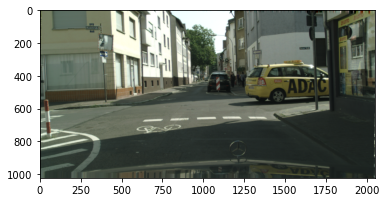

In [6]:
plt.imshow(img_array.astype(np.uint8))

In [7]:
print(img_array.shape)
print(image.shape)
print(img_batch.shape, img_batch.min(), img_batch.max(), img_batch.mean())
print(img_batch_norm.shape, img_batch_norm.min(), img_batch_norm.max(), img_batch_norm.mean())

(1024, 2048, 3)
(800, 1600, 3)
(1, 800, 1600, 3) 0.0 255.0 89.99239
(1, 800, 1600, 3) -123.68 151.061 -24.806952


## 3. 推理

In [8]:
# step3：推理
output_batch = model.predict(img_batch_norm)    # 前向传播
output = np.squeeze(output_batch)               # 剔除batchsize维度
output_idx = np.argmax(output, axis=2)          # 分类概率向量 转为 分类类别

ResourceExhaustedError:  OOM when allocating tensor with shape[1,64,400,800] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node DeepLabV3_Plus/conv1/Conv2D (defined at <ipython-input-8-fcd8d358d302>:2) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_predict_function_7835]

Function call stack:
predict_function


In [ ]:
print(output_batch.shape)
print(output.shape)
print(output_idx.shape, output_idx)

## 4. 上色

In [ ]:
# 读取颜色转换矩阵
id_to_color = read_pkl((path_pkl))

In [ ]:
a = """
                unlabeled |   0 |     255 |           void |          0 |            0 |            1 |         (0, 0, 0)
              ego vehicle |   1 |     255 |           void |          0 |            0 |            1 |         (0, 0, 0)
     rectification border |   2 |     255 |           void |          0 |            0 |            1 |         (0, 0, 0)
               out of roi |   3 |     255 |           void |          0 |            0 |            1 |         (0, 0, 0)
                   static |   4 |     255 |           void |          0 |            0 |            1 |         (0, 0, 0)
                  dynamic |   5 |     255 |           void |          0 |            0 |            1 |      (111, 74, 0)
                   ground |   6 |     255 |           void |          0 |            0 |            1 |       (81, 0, 81)
                     road |   7 |       0 |           flat |          1 |            0 |            0 |    (128, 64, 128)
                 sidewalk |   8 |       1 |           flat |          1 |            0 |            0 |    (244, 35, 232)
                  parking |   9 |     255 |           flat |          1 |            0 |            1 |   (250, 170, 160)
               rail track |  10 |     255 |           flat |          1 |            0 |            1 |   (230, 150, 140)
                 building |  11 |       2 |   construction |          2 |            0 |            0 |      (70, 70, 70)
                     wall |  12 |       3 |   construction |          2 |            0 |            0 |   (102, 102, 156)
                    fence |  13 |       4 |   construction |          2 |            0 |            0 |   (190, 153, 153)
               guard rail |  14 |     255 |   construction |          2 |            0 |            1 |   (180, 165, 180)
                   bridge |  15 |     255 |   construction |          2 |            0 |            1 |   (150, 100, 100)
                   tunnel |  16 |     255 |   construction |          2 |            0 |            1 |    (150, 120, 90)
                     pole |  17 |       5 |         object |          3 |            0 |            0 |   (153, 153, 153)
                polegroup |  18 |     255 |         object |          3 |            0 |            1 |   (153, 153, 153)
            traffic light |  19 |       6 |         object |          3 |            0 |            0 |    (250, 170, 30)
             traffic sign |  20 |       7 |         object |          3 |            0 |            0 |     (220, 220, 0)
               vegetation |  21 |       8 |         nature |          4 |            0 |            0 |    (107, 142, 35)
                  terrain |  22 |       9 |         nature |          4 |            0 |            0 |   (152, 251, 152)
                      sky |  23 |      10 |            sky |          5 |            0 |            0 |    (70, 130, 180)
                   person |  24 |      11 |          human |          6 |            1 |            0 |     (220, 20, 60)
                    rider |  25 |      12 |          human |          6 |            1 |            0 |       (255, 0, 0)
                      car |  26 |      13 |        vehicle |          7 |            1 |            0 |       (0, 0, 142)
                    truck |  27 |      14 |        vehicle |          7 |            1 |            0 |        (0, 0, 70)
                      bus |  28 |      15 |        vehicle |          7 |            1 |            0 |      (0, 60, 100)
                  caravan |  29 |     255 |        vehicle |          7 |            1 |            1 |        (0, 0, 90)
                  trailer |  30 |     255 |        vehicle |          7 |            1 |            1 |       (0, 0, 110)
                    train |  31 |      16 |        vehicle |          7 |            1 |            0 |      (0, 80, 100)
               motorcycle |  32 |      17 |        vehicle |          7 |            1 |            0 |       (0, 0, 230)
                  bicycle |  33 |      18 |        vehicle |          7 |            1 |            0 |     (119, 11, 32)
"""
b = a.strip().split("\n")
label_names = [i.split("|")[0].strip() for i in b]
print(len(label_names))
num_cls = len(label_names)  

for idx, (k, v) in enumerate(id_to_color.items()):
    try:
        print(k, v,label_names[idx])
    except:
        pass
# print(id_to_color)

In [ ]:

# 展示图例
plt.rcParams['figure.figsize'] = (15.0, 15.0)
height = 100
width = 600
fake_img = np.zeros((height*num_cls, width, 3), dtype=np.uint8)

# 上色
for i in range(num_cls):
    color = [*id_to_color[i]]
    fake_img[height*i:height*(i+1), :, :] = color
plt.imshow(fake_img)

# 打字
for i in range(num_cls):
    name = label_names[i]
    plt.text(10, 80 + height*i, name)
plt.show()


In [ ]:
# step4：分类类别矩阵 转为 RGB颜色矩阵
img_color = image.copy()

for i in np.unique(output_idx):     # 遍历输出标签类别，unique类似取集合，不会重复
    if i in id_to_color:
        img_color[output_idx == i] = id_to_color[i]  # 标签是i的位置， 赋值 id_to_color[i]

#### 观察像素(350, 1200)处，  RGB = （0， 0， 142）

In [ ]:
print(img_color.shape, img_color[350, 1200])

In [ ]:
plt.imshow(img_color)

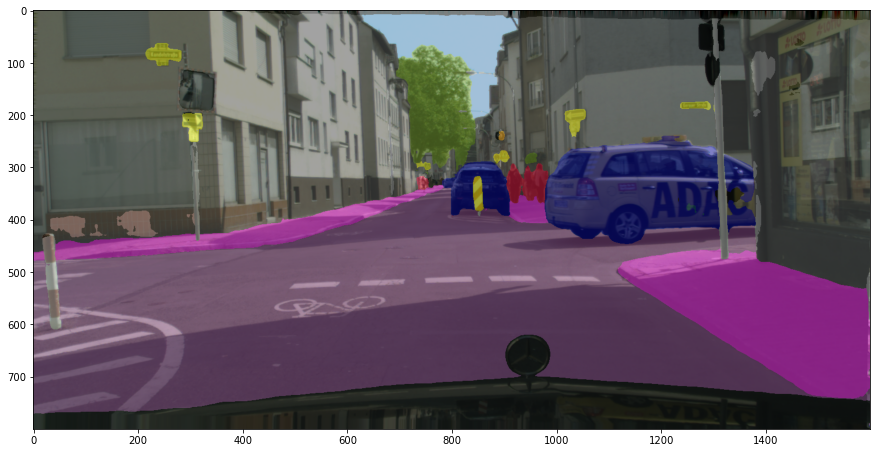

In [16]:
# step5：融合图片，绘图
cv2.addWeighted(image, alpha, img_color, 1 - alpha, 0, img_color)
img_color = img_color.astype(np.uint8)
plt.imshow(img_color)
plt.show()

# cv2.imshow("result", cv2.cvtColor(img_color, cv2.COLOR_RGB2BGR))
# cv2.waitKey()

## DeepLabv3+ 模型结构

In [17]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AveragePooling2D, Lambda, Conv2D, Conv2DTranspose, Activation, Reshape, concatenate, Concatenate, BatchNormalization, ZeroPadding2D
from models.resnet50 import ResNet50


def Upsample(tensor, size):
    '''bilinear upsampling'''
    name = tensor.name.split('/')[0] + '_upsample'

    def bilinear_upsample(x, size):
        resized = tf.image.resize(
            images=x, size=size)
        return resized
    y = Lambda(lambda x: bilinear_upsample(x, size),
               output_shape=size, name=name)(tensor)
    return y


def ASPP(tensor):
    '''atrous spatial pyramid pooling'''
    dims = K.int_shape(tensor)

    # branch1: pooling
    y_pool = AveragePooling2D(pool_size=(
        dims[1], dims[2]), name='average_pooling')(tensor)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same',
                    kernel_initializer='he_normal', name='pool_1x1conv2d', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)

    y_pool = Upsample(tensor=y_pool, size=[dims[1], dims[2]])

    # branch2: dilation rate = 1
    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same',
                 kernel_initializer='he_normal', name='ASPP_conv2d_d1', use_bias=False)(tensor)
    y_1 = BatchNormalization(name=f'bn_2')(y_1)
    y_1 = Activation('relu', name=f'relu_2')(y_1)

    # branch3: dilation rate = 6
    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same',
                 kernel_initializer='he_normal', name='ASPP_conv2d_d6', use_bias=False)(tensor)
    y_6 = BatchNormalization(name=f'bn_3')(y_6)
    y_6 = Activation('relu', name=f'relu_3')(y_6)

    # branch4: dilation rate = 12
    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same',
                  kernel_initializer='he_normal', name='ASPP_conv2d_d12', use_bias=False)(tensor)
    y_12 = BatchNormalization(name=f'bn_4')(y_12)
    y_12 = Activation('relu', name=f'relu_4')(y_12)

    # branch5: dilation rate = 18
    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same',
                  kernel_initializer='he_normal', name='ASPP_conv2d_d18', use_bias=False)(tensor)
    y_18 = BatchNormalization(name=f'bn_5')(y_18)
    y_18 = Activation('relu', name=f'relu_5')(y_18)

    y = concatenate([y_pool, y_1, y_6, y_12, y_18], name='ASPP_concat')

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same',
               kernel_initializer='he_normal', name='ASPP_conv2d_final', use_bias=False)(y)
    y = BatchNormalization(name=f'bn_final')(y)
    y = Activation('relu', name=f'relu_final')(y)
    return y


def DeepLabV3Plus(img_height, img_width, nclasses=66):
    print('*** Building DeepLabv3Plus Network ***')

    # ============================= encoder ========================================
    # backbone
    base_model = ResNet50(input_shape=(img_height, img_width, 3), weights='imagenet', include_top=False)
    image_features = base_model.get_layer('activation_39').output   # 通过这个activation_39拿到这个特征图
    # ASPP 模块
    x_a = ASPP(image_features)
    # ============================= encoder ========================================

    
    # code第一次上采样4倍， 由于下降总共是16倍，这里上采样到原尺寸的4倍，即  16/4=4
    x_a = Upsample(tensor=x_a, size=[img_height // 4, img_width // 4])

    # low level feature process
    x_b = base_model.get_layer('activation_9').output

    # 1*1卷积block
    x_b = Conv2D(filters=48, kernel_size=1, padding='same',
                 kernel_initializer='he_normal', name='low_level_projection', use_bias=False)(x_b)
    x_b = BatchNormalization(name=f'bn_low_level_projection')(x_b)
    x_b = Activation('relu', name='low_level_activation')(x_b)

    x = concatenate([x_a, x_b], name='decoder_concat')

    # 堆叠3*3 卷积block
    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',
               kernel_initializer='he_normal', name='decoder_conv2d_1', use_bias=False)(x)
    x = BatchNormalization(name=f'bn_decoder_1')(x)
    x = Activation('relu', name='activation_decoder_1')(x)
    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',
               kernel_initializer='he_normal', name='decoder_conv2d_2', use_bias=False)(x)
    x = BatchNormalization(name=f'bn_decoder_2')(x)
    x = Activation('relu', name='activation_decoder_2')(x)

    # 上采样恢复尺寸
    x = Upsample(x, [img_height, img_width])

    # 最后一层为1*1卷积，用于生成最终特征图，该特征图通道数为分类类别数
    x = Conv2D(nclasses, (1, 1), name='output_layer')(x)
    '''
    x = Activation('softmax')(x) 
    tf.losses.SparseCategoricalCrossentropy(from_logits=True)
    Args:
        from_logits: Whether `y_pred` is expected to be a logits tensor. By default,
        we assume that `y_pred` encodes a probability distribution.
    '''     
    model = Model(inputs=base_model.input, outputs=x, name='DeepLabV3_Plus')
    print(f'*** Output_Shape => {model.output_shape} ***')
    return model


In [18]:
model.summary()

Model: "DeepLabV3_Plus"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800, 1600, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 806, 1606, 3) 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 400, 800, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 400, 800, 64) 256         conv1[0][0]                      
_____________________________________________________________________________________

<img src="./data/img/deeplabv3plus.png"  width="700" height="700" align="bottom" />